In [1]:
import legwork as lw
import numpy as np
from scipy.integrate import trapz, cumtrapz
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import astropy.units as u
import utils
#import tqdm

In [2]:
m1 = 30 * u.Msun
m2 = 25 * u.Msun
f_LIGO=10*u.Hz
e_LIGO = 1e-4
f_LISA=1e-5*u.Hz


In [3]:
def ecc_integrand(beta, c_0, e):
    integrand = -12/19 * c_0**4 / beta * (1 + (121/304) * e**2)**(1181/2299) / (e**(-29 / 19) * (1 - e**2)**(3/2))
    return integrand

In [4]:
t_obs = np.linspace(0, 4, 10) * u.yr
f_LISA_evol = np.logspace(-5, -1, 100)*u.Hz
t_obs_grid = np.tile(t_obs, (len(f_LISA_evol)))
t_obs_grid = np.reshape(t_obs_grid, (len(f_LISA_evol), len(t_obs)))

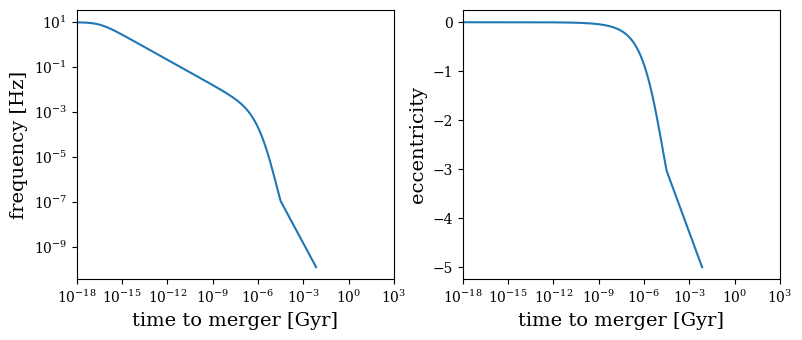

In [5]:
f_LISA_evol = np.logspace(-5, -2, 10)*u.Hz
t_obs = np.linspace(0, 4, 5) * u.yr
nstep=10000
beta = lw.utils.beta(m1, m2)
a_LIGO = lw.utils.get_a_from_f_orb(f_orb=f_LIGO, m_1=m1, m_2=m2)
c_0 = lw.utils.c_0(a_i = a_LIGO, ecc_i=e_LIGO)

ecc_evol = np.logspace(np.log10(e_LIGO - 0.01*e_LIGO), min(np.log10(0.99999), e_LIGO/10), nstep)
ecc_int = ecc_integrand(beta, c_0, e=ecc_evol)
ecc_int = ecc_int.to(u.Gyr)

a_evol = lw.utils.get_a_from_ecc(ecc_evol, c_0=c_0)
f_evol = lw.utils.get_f_orb_from_a(a=a_evol, m_1=m1, m_2=m2)

t_evol = cumtrapz(ecc_int.to(u.Gyr).value, ecc_evol) * u.Gyr
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3.5))

ax1.plot(-1*t_evol, f_evol[1:])
ax2.plot(-1*t_evol, np.log10(1-ecc_evol[1:]))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax1.set_xlabel('time to merger [Gyr]', size=14)
ax2.set_xlabel('time to merger [Gyr]', size=14)

ax1.set_ylabel('frequency [Hz]', size=14)
ax2.set_ylabel('eccentricity', size=14)
ax1.tick_params('both', labelsize=10)
ax2.tick_params('both', labelsize=10)

ax1.set_xlim(1e-18, 1e3)
ax2.set_xlim(1e-18, 1e3)
#ax1.set_ylim(1e-6, 10)
#ax2.set_ylim(1e-10, 1e-1)
plt.tight_layout()

t_interp = interp1d(f_evol.flatten()[1:], t_evol)
t_LISA_evol = t_interp(f_LISA_evol.value) * u.Gyr
t_LISA_evol_grid = np.reshape(np.repeat(t_LISA_evol, len(t_obs)) ,(len(t_LISA_evol), len(t_obs)))
t_LISA_evol_grid_f = (t_LISA_evol_grid + t_obs).to(u.Gyr)
t_LISA_evol_grid_f[t_LISA_evol_grid < t_LISA_evol_grid_f] = t_LISA_evol_grid[t_LISA_evol_grid < t_LISA_evol_grid_f]
#print(f_interp(t_LISA_evol_grid_f.flatten()).reshape(len(t_LISA_evol), len(t_obs)))

In [6]:
def get_evol_LISA(m1, m2, f_LIGO, e_LIGO, f_LISA_evol, ax1, ax2, ii, nstep=10000):
    beta = lw.utils.beta(m1, m2)
    a_LIGO = lw.utils.get_a_from_f_orb(f_orb=f_LIGO, m_1=m1, m_2=m2)
    c_0 = lw.utils.c_0(a_i = a_LIGO, ecc_i=e_LIGO)
    
    ecc_evol = np.logspace(np.log10(e_LIGO - 0.01*e_LIGO), min(np.log10(0.99999), e_LIGO/10), nstep)
    ecc_int = ecc_integrand(beta, c_0, e=ecc_evol)
    ecc_int = ecc_int.to(u.Gyr)
    
    a_evol = lw.utils.get_a_from_ecc(ecc_evol, c_0=c_0)
    f_evol = lw.utils.get_f_orb_from_a(a=a_evol, m_1=m1, m_2=m2)
    
    t_evol = cumtrapz(ecc_int.to(u.Gyr).value, ecc_evol) * u.Gyr
    t_interp = interp1d(f_evol.flatten()[1:], t_evol)
    t_LISA_evol = t_interp(f_LISA_evol.value) * u.Gyr
    
    print(len(ecc_evol))
    ax1.plot(-1*t_evol, f_evol[1:], lw=3-ii)
    ax2.plot(-1*t_evol, ecc_evol[1:], label=r'e$_{\rm{10\,Hz}}$='+f'{e_LIGO:.0e}', lw=4-ii)
    

    
    e_interp = interp1d(f_evol.flatten(), ecc_evol.flatten())
    e_LISA_evol = e_interp(f_LISA_evol.value)
    
    a_interp = interp1d(f_evol.flatten(), a_evol.flatten())
    a_LISA_evol = a_interp(f_LISA_evol.value)
    
    return t_LISA_evol, e_LISA_evol, a_LISA_evol

In [7]:
def get_horizon_distance(m1, m2, f_orb, ecc, SNR_resolve=12, nproc=1):
    dist = 8 * u.kpc
    sources = lw.source.Source(
        m_1=m1 * np.ones(len(f_orb)), m_2=m2 * np.ones(len(f_orb)), 
        dist=dist * np.ones(len(f_orb)), f_orb=f_orb, ecc=ecc, 
        gw_lum_tol=1e-3, interpolate_g=False, n_proc=nproc)
    snr = sources.get_snr()
    d_h = snr/SNR_resolve * dist

    return d_h

10000
10000
10000


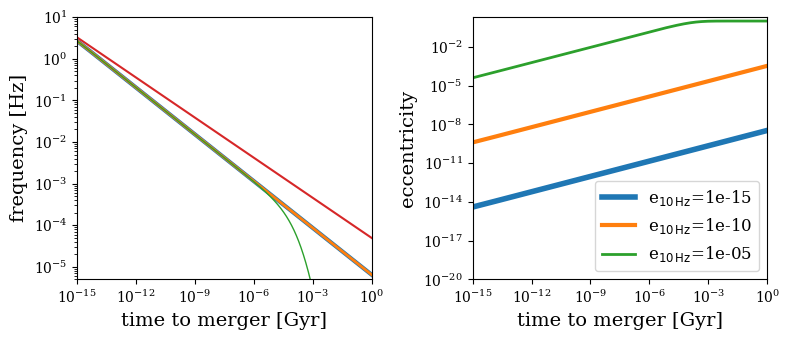

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3.5))

f_LISA_evol = np.logspace(-5, -1, 100)*u.Hz
t_LISA = []
e_LISA = []
d_horizon = []

for ii, e_LIGO in zip(range(3), [1e-15, 1e-10, 1e-5]):
    for m1 in [35*u.Msun]:
        t_LISA_evol, e_LISA_evol, a_LISA_evol = get_evol_LISA(m1, m2, f_LIGO, e_LIGO, f_LISA_evol, ax1, ax2, ii)
        d_h = get_horizon_distance(m1, m2, f_LISA_evol, e_LISA_evol, SNR_resolve=12, nproc=1)
        t_LISA.append(t_LISA_evol)
        e_LISA.append(e_LISA_evol)
        d_horizon.append(d_h)

t_evol = lw.evol.get_t_merge_circ(m_1=m1, m_2=m2, f_orb_i=np.logspace(-6, 1, 1000)*u.Hz)
ax1.plot(t_evol, np.logspace(-5, 1, 1000)*u.Hz)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('time to merger [Gyr]', size=14)
ax2.set_xlabel('time to merger [Gyr]', size=14)

ax1.set_ylabel('frequency [Hz]', size=14)
ax2.set_ylabel('eccentricity', size=14)
ax1.tick_params('both', labelsize=10)
ax2.tick_params('both', labelsize=10)

ax1.set_xlim(1e-15, 1)
ax2.set_xlim(1e-15, 1)
ax1.set_ylim(5e-6, 10)
ax2.set_ylim(1e-20, 2)
ax2.legend(prop={'size':12}, ncol=1)
plt.tight_layout()

plt.savefig('ecc_evol.png', facecolor='white', dpi=200)

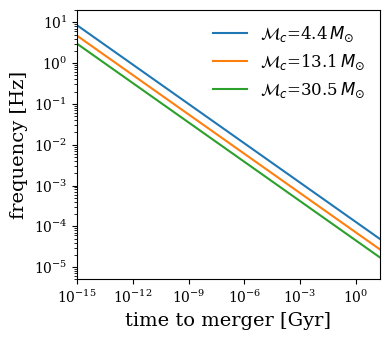

In [9]:
fig, (ax1) = plt.subplots(1, 1, figsize=(4,3.5))

for m1, m2 in zip([5*u.Msun, 15*u.Msun, 35 *u.Msun], [5*u.Msun, 15*u.Msun, 35 *u.Msun]):
    t_evol = lw.evol.get_t_merge_circ(m_1=m1, m_2=m2, f_orb_i=np.logspace(-6, 1, 1000)*u.Hz)
    ax1.plot(t_evol, np.logspace(-5, 1, 1000)*u.Hz, label=r'$\mathcal{M}_c$='+f'{np.round(lw.utils.chirp_mass(m1, m2).value, 1)}'+r'$\,M_{\odot}$')
        
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('time to merger [Gyr]', size=14)

ax1.set_ylabel('frequency [Hz]', size=14)
ax1.tick_params('both', labelsize=10)
ax1.legend(prop={'size':12}, frameon=False)
ax1.set_xlim(1e-15, 20)

ax1.set_ylim(5e-6, 20)
plt.tight_layout()

plt.savefig('circ_evol.png', facecolor='white', dpi=200)

In [10]:
import utils

In [14]:
DTDF_ecc = []
f_dot = []
e_list = []
#for m1, m2 in zip([5*u.Msun, 15*u.Msun, 35 *u.Msun], [5*u.Msun, 15*u.Msun, 35 *u.Msun]):
for m1, m2 in zip([5*u.Msun], [5*u.Msun]):
    for e in [1e-11, 1e-6, 1e-3]:
        beta = lw.utils.beta(m1, m2)
        a_LIGO = lw.utils.get_a_from_f_orb(f_orb=10*u.Hz, m_1=m1, m_2=m2)
        c_0 = lw.utils.c_0(a_i = a_LIGO, ecc_i=e)
        ecc_evol = np.logspace(np.log10(e + 0.01*e), np.log10(0.99999999), 1000000)
        ecc_int = ecc_integrand(beta, c_0, e=ecc_evol)
        ecc_int = ecc_int.to(u.Gyr)
        a_evol = lw.utils.get_a_from_ecc(ecc_evol, c_0=c_0)
        f_evol = lw.utils.get_f_orb_from_a(a=a_evol, m_1=m1, m_2=m2)
        t_evol = cumtrapz(ecc_int.to(u.Gyr).value, ecc_evol) * u.Gyr
        e_interp = interp1d(f_evol.flatten(), ecc_evol.flatten())
        e_LISA_evol = e_interp(f_LISA_evol.value)
        
        a_interp = interp1d(f_evol.flatten(), a_evol.flatten())
        a_LISA_evol = a_interp(f_LISA_evol.value)
        dtdf = utils.dTmerger_df(m1, m2, f_LISA_evol, e_LISA_evol)
        DTDF_ecc.append(dtdf.to(u.s/u.Hz))
        e_list.append(e)
        f_dot.append(lw.utils.fn_dot(lw.utils.chirp_mass(m1, m2), f_LISA_evol, e_LISA_evol, n=1).to(u.Hz**2))

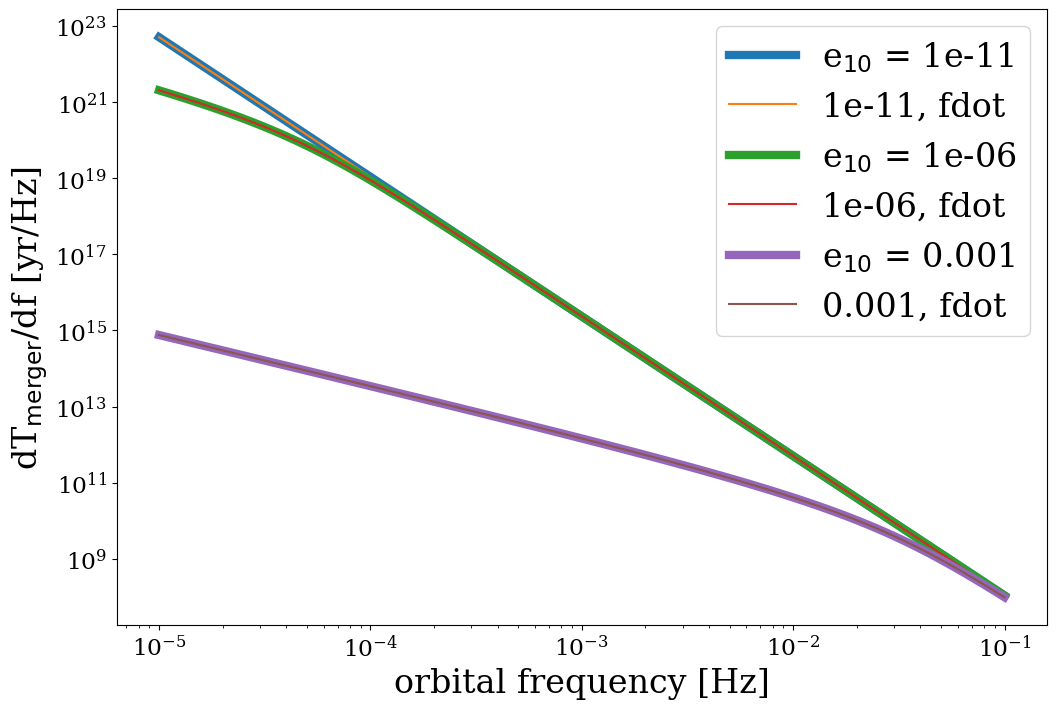

In [15]:
for d, e, f in zip(DTDF_ecc, e_list, f_dot):
    plt.plot(f_LISA_evol, abs(d), label=r'e$_{10}$'+f' = {e}', lw=6)
    plt.plot(f_LISA_evol, 1/f, label=str(e)+', fdot')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('orbital frequency [Hz]')
plt.ylabel(r'dT$_{\rm{merger}}$/df [yr/Hz]')
plt.legend()

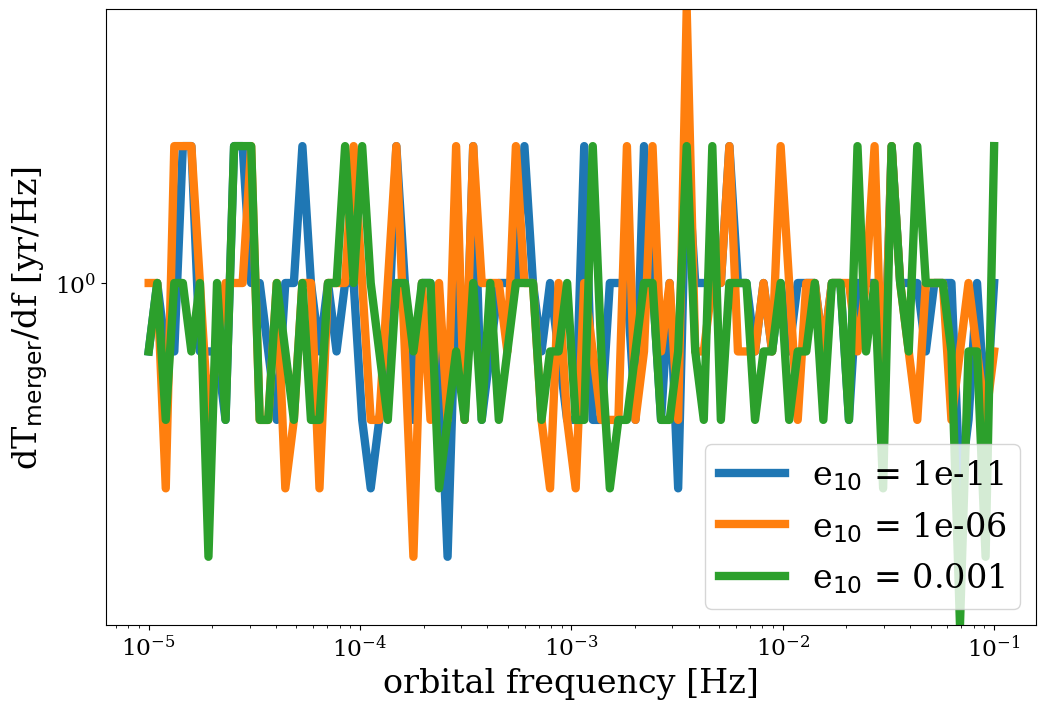

In [16]:
for d, e, f in zip(DTDF_ecc, e_list, f_dot):
    plt.plot(f_LISA_evol, (1/f) / abs(d), label=r'e$_{10}$'+f' = {e}', lw=6)
    #plt.plot(f_LISA_evol, 1/f, label=str(e)+', fdot')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('orbital frequency [Hz]')
plt.ylabel(r'dT$_{\rm{merger}}$/df [yr/Hz]')
plt.legend()